# Doubly robust estimation with Chirho

## Outline

- [Setup](#setup)
- [Overview: Robust Causal Inference with Cut Modules](#overview:-robust-causal-inference-with-cut-modules)
- [Example: Synthetic data generation from a high-dimensional generalized linear model](#example:-synthetic-data-generation-from-a-high-dimensional-generalized-linear-model)
- [Effect estimation using cut modules](#effect-estimation-using-cut-modules)
- [References](#references)

## Setup

In [1]:
import os
import math
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Callable, Dict

import torch
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoNormal
from chirho.indexed.handlers import IndexPlatesMessenger
from chirho.observational.handlers.cut import SingleStageCut
from pyro.infer import Predictive

pyro.settings.set(module_local_params=True)

sns.set_style("white")

pyro.set_rng_seed(321) # for reproducibility

smoke_test = ('CI' in os.environ)
p = 10 if smoke_test else 500
N_train = 10 if smoke_test else 200
N_test = 20 if smoke_test else 500
n_steps = 5 if smoke_test else 5000
num_samples = 10 if smoke_test else 10000

## Overview: Robust causal inference with cut modules

In this notebook, we implement a Bayesian analogue of the DR-Learner estimator in Kennedy (2022). The DR-Learner estimator is a doubly robust estimator for the conditional average treatment effect (CATE). It works by regressing a "pseudo outcome" on treatment, where the "pseudo outcome" is contructed by approximating the outcome and propensity score functions. The DR-Learner estimator is doubly robust in the sense that it is consistent if either the outcome or propensity score models are correctly specified. Moreoever, as long as the outcome and propensity score models can be estimated at $O(N^{-1/4})$ rates, the DR-Learner estimator can estimate CATE at the *parametric* $O(N^{-1/2})$ fast rate.

Due to the two-stage nature of the DR-Learner estimator, we use Chirho's `IndexCutModule` to naturally construct a Bayesian analogue of a two-stage estimator using cut posteriors. Specifically, we use the single-stage variational inference procedure proposed in Carmona et al. (2020) to perform inference.

In [2]:
gaussian_link = lambda mu: dist.Normal(mu, 1.)
bernoulli_link = lambda mu: dist.Bernoulli(logits=mu)

class AbstractDRLearner(pyro.nn.PyroModule):
    """
    AbstractDRLearner is a base class for all DR learners. It is based on the following paper:
    https://arxiv.org/abs/2004.14497.
    """
    def __init__(self, p: int, link_fn: Callable = gaussian_link):
        super().__init__()
        self.p = p
        self.link_fn = link_fn
    
    def _get_module_param(self, param, module_ix):
        if len(param.shape) > 1:
            return param[module_ix].squeeze()
        return param
    
    def sample_propensity_model(self) -> Callable:
        raise NotImplementedError

    def sample_outcome_model(self) -> Callable:
        raise NotImplementedError

    def sample_cate(self) -> Callable:
        raise NotImplementedError
    
    def pseudo_outcome(
        self, D: Dict, propensity_model: Callable, outcome_model: Callable, module_ix: int
    ) -> torch.Tensor:
        X, A, Y = D["X"], D["A"], D["Y"]
        N = X.shape[0]
        propensity_scores = propensity_model(X, module_ix)
        probs = torch.special.expit(propensity_scores)
        outcome_0 = outcome_model(X, torch.zeros(N), module_ix)
        outcome_1 = outcome_model(X, torch.ones(N), module_ix)
        outcome_A = outcome_model(X, A, module_ix)
        traditional_term = outcome_1 - outcome_0  # vanilla cate estimate
        correction_term = (Y - outcome_A) * (A - probs) / (probs * (1 - probs))  # double robustness correction
        return traditional_term + correction_term
    
    def forward(self, D1: Dict, D2: Dict, **kwargs):
        propensity_score = self.sample_propensity_model(**kwargs)
        outcome_model = self.sample_outcome_model(**kwargs)
        cate_model = self.sample_cate(**kwargs)

        # Treatment conditioning
        X1, A1, Y1 = D1['X'], D1['A'], D1['Y']
        with pyro.plate("treatment", X1.shape[0]):
            pyro.sample("A", dist.Bernoulli(logits=propensity_score(X1, 0)), obs=A1)
    
        # Outcome conditioning
        with pyro.plate("outcome", X1.shape[0]):
            pyro.sample("Y", self.link_fn(outcome_model(X1, A1, 0)), obs=Y1)
        
        # pseudo outcome conditioning
        X2 = D2['X']
        Y_pseudo = self.pseudo_outcome(D2, propensity_score, outcome_model, 1)
        with pyro.plate("pseudo_outcome", X2.shape[0]):
            # Hack to get correct conditional dependence structure rendered
            # pyro.sample("Y_pseudo_residuals", dist.Normal(Y_pseudo - cate_model(X2, 1), self.pseudo_noise_scale), obs=torch.zeros(X2.shape[0]))
            pyro.sample("Y_pseudo_residuals", self.link_fn(cate_model(X2, 1)), obs=Y_pseudo)


class LinearDRLearner(AbstractDRLearner):
    def sample_propensity_model(self) -> Callable:
        intercept = pyro.sample("propensity_intercept", dist.Normal(0., 1./math.sqrt(self.p)))
        weights = pyro.sample("propensity_weights", dist.Normal(0., 1./math.sqrt(self.p)).expand((self.p, )).to_event(1))
        return lambda x, module_ix: self._get_module_param(intercept, module_ix) + x @ self._get_module_param(weights, module_ix)

    def sample_outcome_model(self) -> Callable:
        intercept = pyro.sample("outcome_intercept", dist.Normal(0., 1.))
        weights = pyro.sample("outcome_weights", dist.Normal(0., 1.).expand((self.p, )).to_event(1))
        tau = pyro.sample("treatment_weight", dist.Normal(0., 1.))
        return lambda x, a, module_ix: self._get_module_param(intercept, module_ix) + x @ self._get_module_param(weights, module_ix) + a * self._get_module_param(tau, module_ix)

    def sample_cate(self) -> Callable:
        intercept = pyro.sample("cate_intercept", dist.Normal(0., 1.))
        weights = pyro.sample("cate_weights", dist.Normal(0., 1./math.sqrt(self.p)).expand((self.p, )).to_event(1))
        return lambda x, module_ix: self._get_module_param(intercept, module_ix) + x @ self._get_module_param(weights, module_ix)
    

class ATEDRLearner(LinearDRLearner):
    def sample_cate(self) -> Callable:
        intercept = pyro.sample("cate_intercept", dist.Normal(0., 1.))
        return lambda x, module_ix: self._get_module_param(intercept, module_ix)

## Example: Synthetic data generation from a high-dimensional generalized linear model

We use the classes below to generate synthetic data from a high-dimensional generalized linear model. Further, we will use this class to implement the standard outcome-regression approach to estimate CATE. That is, we regress $Y$ on $X$ and $T$ to obtain an estimate of $E[Y | X, A=1] - E[Y | X, A=0]$. This approach is called the "plug-in" approach in Kennedy (2022).

In [3]:
class HighDimLinearModel(pyro.nn.PyroModule):
    def __init__(self, p: int, link_fn: Callable = gaussian_link):
        super().__init__()
        self.p = p
        self.link_fn = link_fn
    
    def sample_outcome_weights(self):
        return pyro.sample("outcome_weights", dist.Normal(0.,  1./math.sqrt(self.p)).expand((self.p, )).to_event(1))

    def sample_treatment_weight(self):
        return pyro.sample("treatment_weight", dist.Normal(0., 1.))

    def forward(self, X: torch.Tensor, A: torch.Tensor):
        N = X.shape[0]
        outcome_weights = self.sample_outcome_weights()
        tau = self.sample_treatment_weight()
        with pyro.plate("obs", N):
            pyro.sample("Y", self.link_fn(X @ outcome_weights + A * tau))
        

class BenchmarkLinearModel(HighDimLinearModel):
    def __init__(self, p: int, link_fn: Callable, alpha: int, beta: int):
        super().__init__(p, link_fn)
        self.alpha = alpha # sparsity of propensity weights
        self.beta = beta # sparisty of outcome weights
    
    def sample_outcome_weights(self):
        outcome_weights = 1 / math.sqrt(self.beta) * torch.ones(self.p)
        outcome_weights[self.beta:] = 0.
        return outcome_weights

    def sample_treatment_weight(self):
        return torch.tensor(0.)


Below we generate synthetic data as in Figure 4b of Kennedy (2022).

In [4]:
p = 500
alpha = 50
beta = 50
N_train = N_train
N_test = N_test
benchmark_model = BenchmarkLinearModel(p, bernoulli_link, alpha, beta)
true_propensity_weights = 1 / math.sqrt(4 * alpha) * torch.ones(p)
true_propensity_weights[alpha:] = 0.
X_train = dist.Normal(0., 1.).expand((N_train, p)).to_event(1).sample()
A_train = dist.Bernoulli(logits=X_train @ true_propensity_weights).sample()
X_test = dist.Normal(0., 1.).expand((N_test, p)).to_event(1).sample()
A_test = dist.Bernoulli(logits=X_test @ true_propensity_weights).sample()

with pyro.poutine.trace() as training_data:
    benchmark_model(X_train, A_train)

with pyro.poutine.trace() as testing_data:
    benchmark_model(X_test, A_test)

Y_train = training_data.trace.nodes["Y"]["value"]
D_train = {"X": X_train, "A": A_train, "Y": Y_train}

Y_test = testing_data.trace.nodes["Y"]["value"]
D_test = {"X": X_test, "A": A_test, "Y": Y_test}

## Effect estimation using cut modules

In [5]:
# Define a helper function to run SVI. (Generally, Pyro users like to have more control over the training process!)
def run_svi_inference(model, n_steps=n_steps, verbose=True, lr=.03, vi_family=AutoNormal, guide=None, **model_kwargs):
    if guide is None:
        guide = vi_family(model)
    elbo = pyro.infer.Trace_ELBO()(model, guide)
    # initialize parameters
    elbo(**model_kwargs)
    adam = torch.optim.Adam(elbo.parameters(), lr=lr)
    # Do gradient steps
    for step in range(1, n_steps + 1):
        adam.zero_grad()
        loss = elbo(**model_kwargs)
        loss.backward()
        adam.step()
        if (step % 1000 == 0) or (step == 1) & verbose:
            print("[iteration %04d] loss: %.4f" % (step, loss))
    return guide

In [6]:
plug_in_model = HighDimLinearModel(p, link_fn=bernoulli_link)
plug_in_model_conditioned = pyro.poutine.condition(plug_in_model, data=D_train)
plug_in_guide = run_svi_inference(plug_in_model_conditioned, vi_family=AutoNormal, n_steps=n_steps, X=X_train, A=A_train)
plug_in_samples_test = Predictive(plug_in_model_conditioned, guide=plug_in_guide, num_samples=num_samples)(X=X_test, A=A_test)

[iteration 0001] loss: 908.8462
[iteration 1000] loss: 228.1193
[iteration 2000] loss: 197.7543
[iteration 3000] loss: 234.1455
[iteration 4000] loss: 224.1710
[iteration 5000] loss: 283.9059


In [7]:
D1 = {"X": X_train[:N_train//2], "A": A_train[:N_train//2], "Y": Y_train[:N_train//2]}
D2 = {"X": X_train[N_train//2:], "A": A_train[N_train//2:], "Y": Y_train[N_train//2:]}

module_one_vars = [
    "propensity_intercept", "propensity_weights", 
    "outcome_intercept", "outcome_weights", 
    "treatment_weight", "A", "Y"
]

def make_cut_model_single(p, module_one_vars, estimator=LinearDRLearner):
    model =  estimator(p)
    def cut_model_single(*args, **kwargs):
        with IndexPlatesMessenger(), SingleStageCut(module_one_vars):
            model(*args, **kwargs)
    return cut_model_single

cut_model_single = make_cut_model_single(p, module_one_vars)
cut_guide_single = run_svi_inference(cut_model_single, vi_family=AutoNormal, n_steps=n_steps, D1=D1, D2=D2)
cut_samples_single = Predictive(cut_model_single, guide=cut_guide_single, num_samples=num_samples)(D1=D1, D2=D2)

/home/rafal/.local/lib/python3.10/site-packages/pyro/util.py:365: UserWarning: Found plate statements in guide but not model: {'__index_plate_____cut_plate'}
  warnings.warn(


[iteration 0001] loss: 28716.6445
[iteration 1000] loss: -1594.4988
[iteration 2000] loss: 5668.5713
[iteration 3000] loss: -2385.5354
[iteration 4000] loss: 702.6427
[iteration 5000] loss: 615.0050


In [8]:
cut_ate_model_single = make_cut_model_single(p, module_one_vars, estimator=ATEDRLearner)
cut_ate_guide_single = run_svi_inference(cut_ate_model_single, vi_family=AutoNormal, n_steps=n_steps, D1=D1, D2=D2)
cut_ate_samples_single = Predictive(cut_ate_model_single, guide=cut_ate_guide_single, num_samples=num_samples)(D1=D1, D2=D2)

[iteration 0001] loss: 35987.4453
[iteration 1000] loss: 11732.2178
[iteration 2000] loss: 3895.3162
[iteration 3000] loss: 1014.4128
[iteration 4000] loss: 3277.1392
[iteration 5000] loss: -1482.6090


Look at how well each method estimates average treatment effect

In [9]:
print("True ATE: 0.0")
print(f"Estimated Treatment Effect (Plug-In): {round(plug_in_guide.median()['treatment_weight'].item(), 3)}")
print(f"Estimated Treatment Effect (CATE DR-Learner): {round(cut_guide_single.median()['cate_intercept'][1].item(), 3)}")
print(f"Estimated Treatment Effect (ATE DR-Learner): {round(cut_ate_guide_single.median()['cate_intercept'][1].item(), 3)}")

True ATE: 0.0
Estimated Treatment Effect (Plug-In): 0.204
Estimated Treatment Effect (CATE DR-Learner): -0.168
Estimated Treatment Effect (ATE DR-Learner): 0.059


Because we use Bayesian inference, we also get uncertainity estimates for ATE


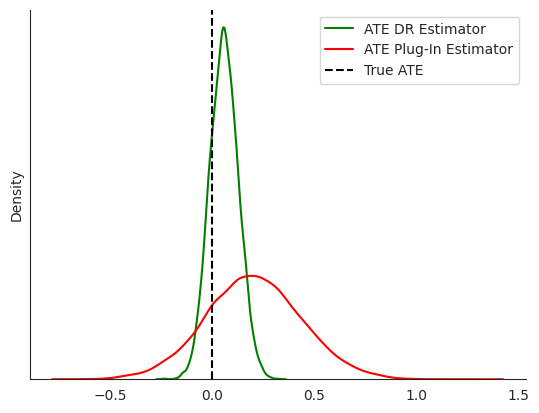

In [10]:
fig, ax = plt.subplots()
sns.kdeplot(
    cut_ate_samples_single['cate_intercept'][:, 1, ...].squeeze(), 
    label="ATE DR Estimator", ax=ax, color='green'
)

sns.kdeplot(
    plug_in_samples_test['treatment_weight'].squeeze(), 
    label="ATE Plug-In Estimator", ax=ax, color='red'
)

ax.axvline(0, color="black", label="True ATE", linestyle="--")
ax.set_yticks([])
sns.despine()
ax.legend(loc="upper right")

## References

Kennedy, Edward. "Towards optimal doubly robust estimation of heterogeneous causal effects", 2022. https://arxiv.org/abs/2004.14497.

Carmona, Chris U., Geoff K. Nicholls. "Semi-Modular Inference: enhanced learning in multi-modular models by tempering the influence of components", 2020. https://arxiv.org/abs/2003.06804.
